Here, we introduce the process of training the ASGCNN model to predict adsorption energies. 

The ASGCNN implementation in this project differs from the [previous one](https://github.com/jchddd/asgcnn/) in several key aspects:
- Framework: This project's network is built entirely upon PyTorch and PyTorch Geometric, whereas the previous version relied more heavily on DGL.
- Functionality: The current network exclusively supports the ASGCNN framework, meaning the input configurations require an adsorbed molecule. In contrast, the previous framework offered greater flexibility.
- Training Structure: To accommodate extended surfaces, this framework requires training on the N-th nearest neighbor structure of the adsorption site, while the previous framework utilized the slab structure for training.  

# Load Data

First, converte structures from the ASE database into graph-structured data and add features. The parameters for the feature-addition functions have been pre-stored in **para**.


In [8]:
from heaict.para import para_add_feat, para_grab_feature
from heaict.data.dataset import load_graph_from_database

In [3]:
graphs = load_graph_from_database(
    f'Data/Adss_data/train_data.db',
    targets=['G', 'Cadsb', 'Csite'],
    save=False,
    disable_tqdm=False,
    para_grab_ele_feature=para_grab_feature,
    para_add_feature=para_add_feat
)

  0%|          | 0/8719 [00:00<?, ?it/s]

# Model Training
Subsequently, the machine learning model is trained using the **trainer** module. Future tasks, such as visualizing the training outcomes and predicting unknown structures, will also depend on this module.   

For convenience, the hyperparameters for both the machine learning model and the training process adopt the settings from the literature, which are also stored in **para**.  

Of course, since the dataset split and the random seed for the entire process are not fixed, different results will be obtained.

In [9]:
from heaict.ml.trainer import trainer
from heaict.ml.mode import GNN
from heaict.para import para_model, para_trainer

In [11]:
model = GNN(**para_model)
t = trainer(model=model, graph_list=graphs, **para_trainer)

For other specific details regarding the model and the trainer, please refer to their respective documentation.

In [ ]:
trainer?

In [ ]:
GNN?

In [14]:
t.split_train_valid_test(train_ration=0.8, valid_ration=0, test_ration=0.2)

In [16]:
t.train(print_info=True, print_interval=10)

start training:
epoch | loss_train | loss_valid | loss_test
    0 |   0.605025 |   0.000000 |   0.706567
    9 |   0.103521 |   0.000000 |   0.093111
   19 |   0.085581 |   0.000000 |   0.082431
   29 |   0.078651 |   0.000000 |   0.074438
   39 |   0.078655 |   0.000000 |   0.075604
   49 |   0.071717 |   0.000000 |   0.077600
   59 |   0.072768 |   0.000000 |   0.079022
   69 |   0.065709 |   0.000000 |   0.078557
   79 |   0.060757 |   0.000000 |   0.073928
   89 |   0.059119 |   0.000000 |   0.073002
   99 |   0.059001 |   0.000000 |   0.074350
  109 |   0.055371 |   0.000000 |   0.074032
  119 |   0.058531 |   0.000000 |   0.072882
  129 |   0.053506 |   0.000000 |   0.078238
  139 |   0.052863 |   0.000000 |   0.076537
  149 |   0.051803 |   0.000000 |   0.075784
  159 |   0.048739 |   0.000000 |   0.076196
  169 |   0.048675 |   0.000000 |   0.077150
  179 |   0.049620 |   0.000000 |   0.074126
  189 |   0.044065 |   0.000000 |   0.077001
  199 |   0.048141 |   0.000000 |   0.07

You can quickly view and visualize the training results using the following two methods.

In [20]:
t.calculate_metrics()

=== train ===
MAE:       0.059 | MSE:        0.007 | RMSE:    0.086 | R2:  0.988
Accuracy:  1.000 | Precision:  1.000 | Recall:  1.000 | F1:  1.000 | Precisions: 1.0 1.0 1.0 1.0 1.0 1.0 1.0 | Recalls: 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Accuracy:  1.000 | Precision:  1.000 | Recall:  1.000 | F1:  1.000 | Precisions: 1.0 1.0 1.0 | Recalls: 1.0 1.0 1.0
=== test ===
MAE:       0.103 | MSE:        0.022 | RMSE:    0.149 | R2:  0.964
Accuracy:  1.000 | Precision:  1.000 | Recall:  1.000 | F1:  1.000 | Precisions: 1.0 1.0 1.0 1.0 1.0 1.0 1.0 | Recalls: 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Accuracy:  1.000 | Precision:  1.000 | Recall:  1.000 | F1:  1.000 | Precisions: 1.0 1.0 1.0 | Recalls: 1.0 1.0 1.0


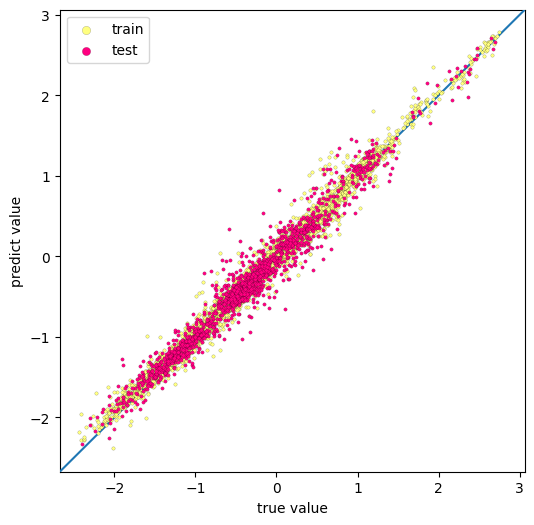

In [21]:
t.show_result()

To make predictions, provide a model and a DataLoader (we use the test DataLoader here for demo).   

For unknown structures: generate the ASE database as before, convert to graphs, and load them into the DataLoader.

In [26]:
predict = t.get_predict(model=t.model, loader=t.loaders['test'])

In [27]:
predict

[array([ 0.4995033 , -0.4540037 , -0.8741876 , ...,  0.9606273 ,
        -0.32906443,  0.983861  ], dtype=float32),
 array([3, 6, 3, ..., 2, 3, 3], dtype=int64),
 array([2, 1, 2, ..., 0, 2, 1], dtype=int64)]

# Hyperparameter Search

For hyperparameter search, we recommend using the **Optuna** software. For specific usage instructions, please refer to its [documentation](https://optuna.readthedocs.io/en/stable/). Below is a simple demonstration.

In [31]:
import optuna
from heaict.ml.utility import fix_seed

In [ ]:
def objective(trial):
    fix_seed(6789)

    node_feat_dim   = 68
    edge_feat_dim   = 18
    hidd_feat_dim   = trial.suggest_int('hidd_feat_dim', 18, 36, 3)
    conv_model      = 'cluster-sg' # trial.suggest_categorical('conv_model', ['cluster-sg'])

    # conv_sub
    num_conv_sub    = trial.suggest_int('num_conv_sub', 2, 3, 4)
    conv_typ_sub    = 'cgc' # 'gat'
    conv_kwargs_sub = {
            'weight_by_edge': False, # trial.suggest_categorical('weight_by_edge_sub', [True, False]),
            'cat_edge':trial.suggest_categorical('cat_edge_sub', [True, False]),
            # 'num_heads': heads_sub, # hyperparameters for GAT layer
            # 'out_feat_dim': int(hidd_feat_dim / heads_sub),
            # 'feat_for_weight': 'xi|xj' if conv_model in ['cluster', 'distance'] else 'xi|xj|ea',
            # 'feat_for_aggr': 'xi|xj' if conv_model in ['cluster', 'distance'] else 'xi|xj|ea',
            'residual': trial.suggest_categorical('residual_sub', [True, False]),
    }

    # conv_ads
    num_conv_ads    = trial.suggest_int('num_conv_ads', 2, 3, 4)
    conv_typ_ads    = 'cgc' # 'gat'
    conv_kwargs_ads = {
            'weight_by_edge': False, # trial.suggest_categorical('weight_by_edge_ads', [True, False]),
            'cat_edge':trial.suggest_categorical('cat_edge_ads', [True, False]),
            # 'num_heads': heads_ads,
            # 'out_feat_dim': int(hidd_feat_dim / heads_ads),
            # 'feat_for_weight': 'xi|xj|ea',
            # 'feat_for_aggr': 'xi|xj|ea',
            'residual': trial.suggest_categorical('residual_ads', [True, False]),
    }
    
    # att
    att_type        = trial.suggest_categorical('att_type', ['linear', 'self', 'global', 'none'])
    self_att = True if att_type == 'self' else False
    glob_att = True if att_type == 'global' else False
    line_att = True if att_type == 'linear' else False
    # predict
    pool            = trial.suggest_categorical('pool', ['mean', 'sum'])
    fcl_cl_len      = trial.suggest_int('fcl_cls_dim', 36, 72, 4)
    fcl_cl_dim      = [fcl_cl_len, int(fcl_cl_len / 2)]
    fcl_en_len      = trial.suggest_int('fcl_eng_dim', 36, 72, 4)
    fcl_en_dim      = [fcl_en_len, int(fcl_en_len / 2), int(fcl_en_len / 4)]
    acti            = trial.suggest_categorical('acti', ['silu', 'relu', 'gelu', 'sigmoid', 'tanh', 'leakyrelu'])

    # classfy
    beta        = trial.suggest_float('beta', 0.05, 1.0)
    metric_type = trial.suggest_categorical('metric_type', ['rmse', 'mae'])
    classf_weig = trial.suggest_float('class_weight', 0.93, 0.99)
    metric = [metric_type, classf_weig, 7, 3, beta]
    
    graph_list = torch.load(f'Data/Example/db_and_ML/graphs.pt') # use you own .pt file
    
    model = GNN(
        node_feat_dim=node_feat_dim,
        edge_feat_dim=edge_feat_dim,
        hidd_feat_dim=hidd_feat_dim,
        
        conv_model=conv_model,
        
        conv_typ_sub=conv_typ_sub,
        num_conv_sub=num_conv_sub,
        conv_kwargs_sub=conv_kwargs_sub,
        
        conv_typ_ads=conv_typ_ads,
        num_conv_ads=num_conv_ads,
        conv_kwargs_ads=conv_kwargs_ads,

        self_att=self_att,
        max_num_nodes_sub=67,
        max_num_nodes_ads=7,
        self_att_sub_kwargs={'num_heads': 3, 'residual_att': True},
        self_att_ads_kwargs={'num_heads': 3, 'residual_att': True},
        line_att=line_att,
        glob_att=glob_att,

        pool=pool,
        
        fcl_cl_dim=fcl_cl_dim,
        fcl_en_dim=fcl_en_dim,
        
        acti=acti,
        classify=True,
        num_adsb=7
    )

    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    lr         = trial.suggest_categorical('lr', [0.01, 0.001, 0.0001])
    weight_dec = trial.suggest_categorical('weight_dec', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

    t = trainer(
        model=model,
        graph_list=graph_list,
        epoch=100,
        batch=batch_size,
        metric=metric,
        optimizer=['AdamW', lr, weight_dec],
        scheduler=['ConstantLR'], # 'CosineAnnealingLR', 'StepLR', 'ConstantLR'
        max_norm=10
    )
    
    t.split_train_valid_test(0.9, 0, 0.1)
    t.train(use_train_loss=False, print_info=False, print_interval=1, early_stop=True, patience=16)
    d = t.calculate_metrics(print_metric=False, to_dict=True)

    obj=d['test']['Eads']['rmse']

    return obj

In [ ]:
study = optuna.create_study(direction='minimize')

In [ ]:
study.optimize(objective, 100)

In [ ]:
study.best_params